## Understanding Data Processing Code

You are going to complete two tasks that involve finding bugs. The notebook has been divided into two parts; each part contains a data processing bug that makes the model performance worse in later stages. **Could you locate the bugs in the notebook?**

### Instruction
+ You have **12 minutes** to complete each task. Complete each task one at a time. Each task contains only **one bug**.
+ Feel free to **use the Internet** to search for any problems you might encounter.
+ Feel free to **run the notebooks or add new statements** to run to satisfy your needs.
+ You should focus on **data processing** mostly. Try to understand the intention and effect of the code. Bugs are likely to result from **mismatch between user intention and actual effect**.


In [1]:
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', category=DeprecationWarning)

import pandas as pd
pd.options.display.max_columns = 100

from matplotlib import pyplot as plt
import numpy as np

In [2]:
# first, let's define a print function that asserts whether or not a feature has been processed. 
def status(feature):
    print('Processing', feature, ': ok')

###  Loading the data

In [3]:
# reading train data
train = pd.read_csv('./data/train.csv')
train_len = len(train)

# reading test data
test = pd.read_csv('./data/test.csv')

# extracting and then removing the targets from the training data 
targets = train.Survived
train.drop(['Survived'], 1, inplace=True)


# merging train data and test data for future feature engineering
# we'll also remove the PassengerID since this is not an informative feature
combined = train.append(test)
combined.reset_index(inplace=True)
combined.drop(['index', 'PassengerId'], inplace=True, axis=1)
combined

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...
1304,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
1305,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
1306,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
1307,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S


# --------------- Task1 BEGINs ---------------

### Processing Title
This function parses the names and extract the titles. Then, it maps all possible titles to **categories of titles, or "Unknown"**.

In [4]:
Title_Dictionary = {
    "Capt": "Officer",
    "Col": "Officer",
    "Major": "Officer",
    "Sir" : "Royalty",
    "Dr": "Officer",
    "the Countess":"Royalty",
    "Mme": "Mrs",
    "Mlle": "Miss",
    "Ms": "Mrs",
    "Mr" : "Mr",
    "Mrs" : "Mrs",
    "Miss" : "Miss",
    "Master" : "Master",
    "Lady" : "Royalty",    
    "Jonkheer": "Unknown",
    "Don": "Unknown",
    "Dona": "Unknown"
}

# we extract the title from each name
combined['Title'] = combined['Name'].map(lambda name:name.split(',')[1].split('.')[0].strip())

# we map each possible title to more aggregated title
combined['Title'] = combined.Title.map(Title_Dictionary)
status('Title')

Processing Title : ok


### Processing Ages
Let's fill missing age based on median of each group.

In [5]:
grouped_train = combined.iloc[:train_len].groupby(['Sex','Pclass','Title'])
grouped_median_train = grouped_train.median()
grouped_median_train = grouped_median_train.reset_index()[['Sex', 'Pclass', 'Title', 'Age']]

def fill_age(row):
    condition = (
        (grouped_median_train['Sex'] == row['Sex']) & 
        (grouped_median_train['Title'] == row['Title']) & 
        (grouped_median_train['Pclass'] == row['Pclass'])
    ) 
    return grouped_median_train[condition]['Age'].values[0] if np.isnan(row['Age']) else row['Age']

combined['Age'] = combined.apply(lambda row: fill_age(row), axis=1)
status('age')

Processing age : ok


Let's now process the names.

In [6]:
# we clean the Name variable
combined.drop('Name', axis=1, inplace=True)

# encoding in dummy variable
titles_dummies = pd.get_dummies(combined['Title'], prefix='Title')
combined = pd.concat([combined, titles_dummies], axis=1)

# removing the title variable
combined.drop('Title', axis=1, inplace=True)

status('names')

Processing names : ok


### Processing Embarked

In [7]:
# two missing embarked values - filling them with the most frequent one in the train  set(S)
combined.Embarked.fillna('S', inplace=True)
# dummy encoding 
embarked_dummies = pd.get_dummies(combined['Embarked'], prefix='Embarked')
combined = pd.concat([combined, embarked_dummies], axis=1)

combined.drop('Embarked', axis=1, inplace=True)
status('embarked')

Processing embarked : ok



# --------------- Task1 ENDs ---------------

# --------------- Task2 BEGINs ---------------


### Processing Cabin

This function replaces NaN values with U (for <i>Unknow</i>). It then maps each Cabin value to the first letter.
Then it encodes the cabin values using dummy encoding again.

In [8]:
# replacing missing cabins with U (for Uknown)
combined.Cabin.fillna('U', inplace=True)

# mapping each Cabin value with the cabin letter
combined['Cabin'] = combined['Cabin'].map(lambda c: c[0])

# dummy encoding ...
cabin_dummies = pd.get_dummies(combined['Cabin'], prefix='Cabin')    
combined = pd.concat([combined, cabin_dummies], axis=1)

combined.drop('Cabin', axis=1, inplace=True)
status('cabin')

Processing cabin : ok


### Processing Sex

This function maps the string values male and female to 1 and 0 respectively. 

In [9]:
# mapping string values to numerical one 
combined['Sex'] = combined['Sex'].map({'male':1, 'female':0})
status('Sex')

Processing Sex : ok


### Processing Fare

In [10]:
# there's one missing fare value - replacing it with the mean.

combined.Fare.fillna(combined.iloc[:train_len].Fare.mean())
status('fare')

Processing fare : ok


### Processing Pclass

This function encodes the values of Pclass (1,2,3) using a dummy encoding.

In [11]:
# encoding into 3 categories:
pclass_dummies = pd.get_dummies(combined['Pclass'], prefix="Pclass")

# adding dummy variable
combined = pd.concat([combined, pclass_dummies],axis=1)

# removing "Pclass"
combined.drop('Pclass',axis=1,inplace=True)

status('Pclass')

Processing Pclass : ok


### Processing Ticket

In [12]:
# a function that extracts each prefix of the ticket, returns 'XXX' if no prefix (i.e the ticket is a digit)
def cleanTicket(ticket):
    ticket = ticket.replace('.','')
    ticket = ticket.replace('/','')
    ticket = ticket.split()
    ticket = map(lambda t : t.strip(), ticket)
    ticket = list(filter(lambda t : not t.isdigit(), ticket))
    if len(ticket) > 0:
        return ticket[0]
    else: 
        return 'XXX'


# Extracting dummy variables from tickets:

combined['Ticket'] = combined['Ticket'].map(cleanTicket)
tickets_dummies = pd.get_dummies(combined['Ticket'], prefix='Ticket')


combined = pd.concat([combined, tickets_dummies], axis=1)
combined.drop('Ticket', inplace=True, axis=1)

status('Ticket')

Processing Ticket : ok


### Processing Family

In [13]:
# introducing a new feature : the size of families (including the passenger)
combined['FamilySize'] = combined['Parch'] + combined['SibSp'] + 1

# introducing other features based on the family size
combined['Singleton'] = combined['FamilySize'].map(lambda s: 1 if s == 1 else 0)
combined['SmallFamily'] = combined['FamilySize'].map(lambda s: 1 if 2 <= s <= 4 else 0)
combined['LargeFamily'] = combined['FamilySize'].map(lambda s: 1 if 5 <= s else 0)

status('family')

Processing family : ok


# --------------- Task2 ENDs ---------------

# III - Modeling

In [14]:
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

In [15]:
def compute_score(clf, X, y, scoring='accuracy'):
    xval = cross_val_score(clf, X, y, cv = 5, scoring=scoring)
    return np.mean(xval)

Recovering the train set and the test set from the combined dataset is an easy task.

In [16]:
targets = pd.read_csv('./data/train.csv', usecols=['Survived'])['Survived'].values
train = combined.iloc[:train_len]
test = combined.iloc[train_len:]

## Feature selection

In [17]:
clf = RandomForestClassifier(n_estimators=50, max_features='sqrt')
clf = clf.fit(train, targets)

<AxesSubplot:ylabel='feature'>

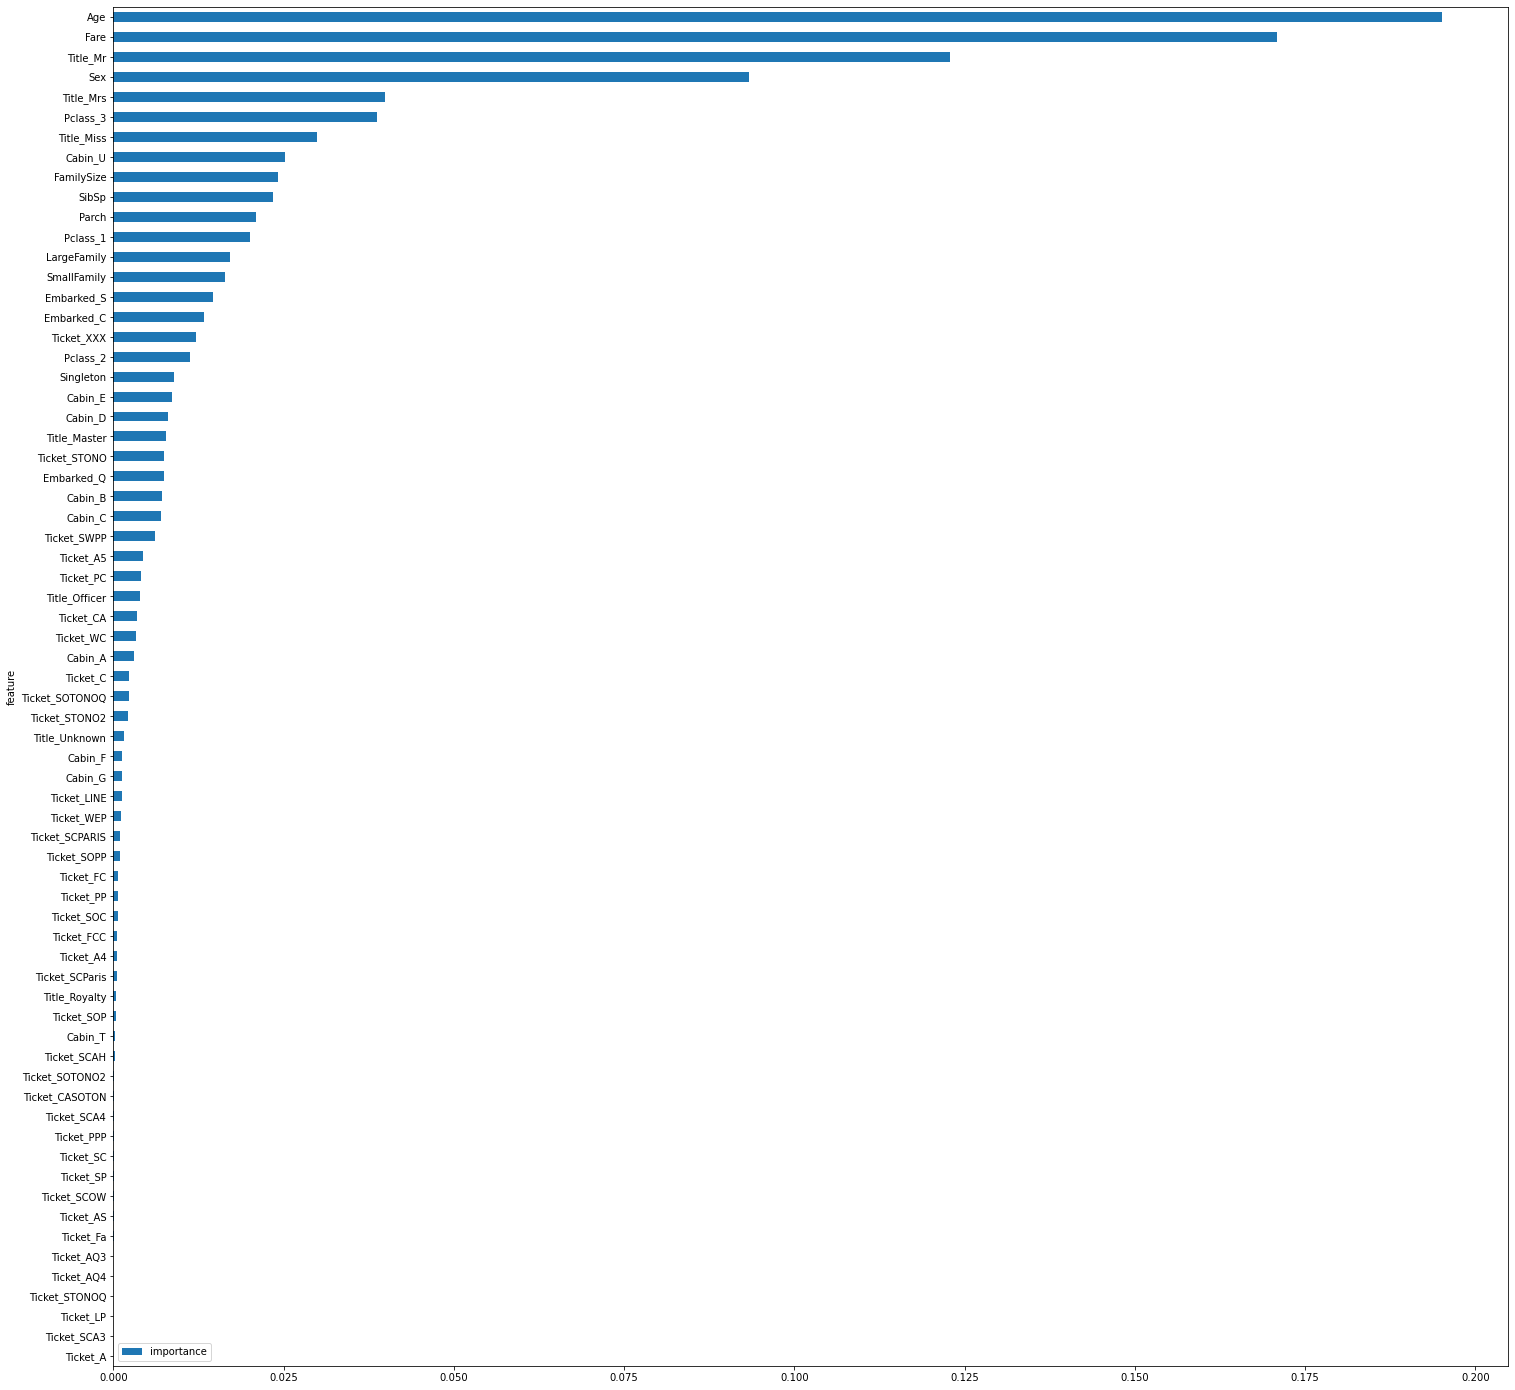

In [18]:
features = pd.DataFrame()
features['feature'] = train.columns
features['importance'] = clf.feature_importances_
features.sort_values(by=['importance'], ascending=True, inplace=True)
features.set_index('feature', inplace=True)

features.plot(kind='barh', figsize=(25, 25))